In [1]:
import logging
import h5py
import dill
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Functionals as FUNC
import TransportMaps.Maps as MAPS
import TransportMaps.Distributions as DIST
%matplotlib inline
TM.setLogLevel(logging.INFO)

# Sparse transports for Markov random fields

Markov properties of the target distribution $\nu_\pi$ can be exploited in order to derive efficient low-dimensional approximations [[TR4]](aa-references.html#spantini2017). We alreadi discussed ([here](example-sequential-stocvol-6d.html)) the decomposability of direct transports $T$. Here we present explore the sparsity of the inverse transport $S$.

We use again the stochastic volatility model as an example. See [[OR7]](aa-references.html#Hull1987) and [[OR8]](aa-references.html#Kim1998) for a presentation of the problem. We use the solution to the [sequential inference problem](example-sequential-stocvol-6d.html) to create a synthetic example, i.e. to generate a sample for which we will assume not to know its origin.

Let us load such a sample (we use a $10^4$ long Markov chain from $\nu_\pi$) ...

In [2]:
f = h5py.File("aux/inv-stocvol/Sequential-IntSq-Postprocess.dill.hdf5")
x = f['metropolis-independent-proposal-samples']['x'][:]
w = np.ones(x.shape[0]) / float(x.shape[0])
f.close()

Let us then define the distribution $\nu_\pi$ ...

In [3]:
class StocVol(DIST.Distribution):
    def __init__(self, x):
        super(StocVol,self).__init__(x.shape[1])
        self.x = x
    def quadrature(self, qtype, qparams, *args, **kwargs):
        if qtype == 1: # We use 1 to indicate a Markov chain
            nmax = self.x.shape[0]
            if qparams > nmax:
                raise ValueError("Maximum sample size (%d) exceeded" % nmax)
            x = self.x[:qparams,:]
            w = np.ones(qparams)/float(qparams)
        else: raise ValueError("Quadrature not defined")
        return (x,w)
pi = StocVol(x)

Let us now define a simple linear transformation that rescales the position of the sample to the hyper-cube $[-4,4]$ (as in the [introductory example](example-inverse-gumbel-1d.html)) ...

In [4]:
a = np.zeros(pi.dim)
b = np.zeros(pi.dim)
for d in range(pi.dim):
    xmax = np.max(x[:,d])
    xmin = np.min(x[:,d])
    a[d] = 4*(xmin+xmax)/(xmin-xmax)
    b[d] = 8./(xmax-xmin)
L = MAPS.FrozenLinearDiagonalTransportMap(a, b)

## Sparse inverse transports

We know by construction that the stochastic volatility model will have the following Markov structure:

![](Figures/SequentialHiddenMarkovModel.png)

where $\Theta=(\mu,\phi)$ and ${\bf Z}_k \in \mathbb{R}$. Using the theory on sparse inverse transports [[TR4]](aa-references.html#spantini2017) we then expect $S$ to have the following sparsity structure:

![](Figures/inv-sparsity.svg)

Let us then assemble the map $S$ of total order 3.

In [11]:
order = 2
active_vars = [[0], [0,1], [0,1,2], [0,1,2,3],
               [0,1,3,4], [0,1,4,5]]
S = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    6, order, 'total', active_vars=active_vars)
print("Number of coefficients: %d" % S.n_coeffs)

Number of coefficients: 64


## Variational solution

We can now set up the problem

$$
\hat{S} = \arg\min_{S\in\mathcal{T}_\triangle} \mathcal{D}_{\rm KL}
\left( S_\sharp L_\sharp \nu_\pi \middle\Vert \nu_\rho \right) \;,
$$

where $\mathcal{T}_\triangle$ is the set of [integrated squared triangular transport maps](api-TransportMaps-Maps.html#TransportMaps.Maps.IntegratedSquaredTriangularTransportMap) (presented [here](example-gumbel-1d.html#Integrated-squared-parametrization)) of (total) order 3 and with the aforementioned sparsity pattern.

In [12]:
rho = DIST.StandardNormalDistribution(6)
push_L_pi = DIST.PushForwardTransportMapDistribution(L, pi)
push_SL_pi = DIST.PushForwardTransportMapDistribution(
    S, push_L_pi)
qtype = 1      # Monte-Carlo quadratures from pi
qparams = 5000 # Number of MC points
reg = {'type': 'L2',
       'alpha': 1e-2} # L2 regularization
tol = 1e-3     # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_SL_pi.minimize_kl_divergence(
    rho, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation: Optimization terminated successfully
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   Function value:          1.229343
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   Norm of the Jacobian:    0.000303
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   Number of iterations:         4
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   N. function evaluations:      5
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   N. Jacobian evaluations:      8
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   N. Hessian evaluations:       4
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation: Optimization terminated successfully
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSquaredApproximation:   Function value:          1.330919
2017-08-15 12:35:07 INFO: TM.MonotonicIntegratedSqua

Note that the solutioon of this variational problem **does not require** any evaluation of the density $\pi$, but only evaluations of $\rho$, which is trivial.

### Accuracy of the approximation

In general the accuracy of this approximation cannot be evaluated as with the diagnostics presented for the direct approach, due to the un-availability of the density $\pi$.

For the sake of the presentation, though, we will compare the approximation $L^\sharp S^\sharp \rho$ against the actual density $\pi$, to check its accouracy.

In [13]:
with open("aux/inv-stocvol/Distribution.dill", 'rb') as in_stream:
    pi_star = dill.load(in_stream)

#### Variance diagnostic

We compute the quantity $\mathbb{V}{\rm ar}_\pi \left( \log \frac{L^\sharp S^\sharp \rho}{\pi} \right)$ ...

In [14]:
import TransportMaps.Diagnostics as DIAG
SL = MAPS.CompositeTransportMap(S, L)
pull_SL_rho = DIST.PullBackTransportMapDistribution(SL, rho)
var = DIAG.variance_approx_kl(pull_SL_rho, pi_star, x=x, w=w)
print("Variance diagnostic: %e" % var)

Variance diagnostic: 4.474835e-01


#### PushForward conditionals

We can plot slices of $S_\sharp L_\sharp \nu_\pi \approx \nu_\rho \sim \mathcal{N}(0,{\bf I})$ ...

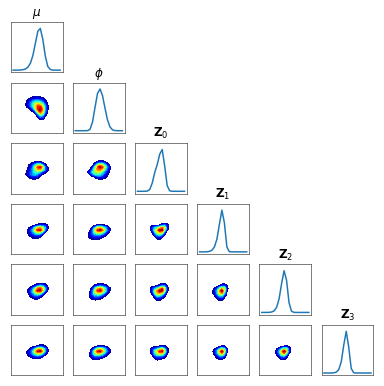

In [15]:
push_SL_pi_star = DIST.PushForwardTransportMapDistribution(SL, pi_star)
fig = DIAG.plotAlignedConditionals( push_SL_pi_star, range_vec=[-5,5], 
    numPointsXax=20, fig=plt.figure(figsize=(6.5,6.5)), show_flag=False,
    vartitles=[r"$\mu$",r"$\phi$",r"${\bf Z}_0$",r"${\bf Z}_1$",r"${\bf Z}_2$",r"${\bf Z}_3$"])